# Pokemon Generation and Interpolation
This project uses a Variational Autoencoder to encode 128x128 pixel images of pokemon to a 1000 dimensional latent space. Then decodes this latent vector to another 128x128 image.

For more details see www.benedekpapp.page/projects/pokemon-generation-and-interpolation


### Getting data

This Pokemon dataset was published on Kaggle, it is downloaded from a my GDrive as the kaggle link was not working at the time of making.
Dataset source 'https://www.kaggle.com/kvpratama/pokemon-images-dataset'

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XvSDB1N2ytYZ6d_grMQrhRlmIsO746k6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XvSDB1N2ytYZ6d_grMQrhRlmIsO746k6" -O Large.zip && rm -rf /tmp/cookies.txt

--2020-08-29 10:24:59--  https://docs.google.com/uc?export=download&confirm=CjhB&id=1XvSDB1N2ytYZ6d_grMQrhRlmIsO746k6
Resolving docs.google.com (docs.google.com)... 108.177.126.102, 108.177.126.139, 108.177.126.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-28-docs.googleusercontent.com/docs/securesc/tn4pj8j8jadmtvfuf3pb7fselomm9l83/u8qn5gjrqqqflupalsnglv0o80b19v80/1598696625000/04111600379416530047/17339607233622191703Z/1XvSDB1N2ytYZ6d_grMQrhRlmIsO746k6?e=download [following]
--2020-08-29 10:24:59--  https://doc-08-28-docs.googleusercontent.com/docs/securesc/tn4pj8j8jadmtvfuf3pb7fselomm9l83/u8qn5gjrqqqflupalsnglv0o80b19v80/1598696625000/04111600379416530047/17339607233622191703Z/1XvSDB1N2ytYZ6d_grMQrhRlmIsO746k6?e=download
Resolving doc-08-28-docs.googleusercontent.com (doc-08-28-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Conne

Unzipping and removing zip file

In [24]:
!unzip Large.zip

unzip:  cannot find or open Large.zip, Large.zip.zip or Large.zip.ZIP.


In [25]:
!rm *.zip

rm: cannot remove '*.zip': No such file or directory


### Importing the data
Images are loaded into a list from the data folder after being rescaled to 128x128 pixels, for interacting with the model images are rescaled into the 0-1 float range.

In [26]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

In [27]:
image_files = os.listdir('pokemon_jpg/pokemon_jpg')
imgs = []
for image_file in image_files:
  img = cv2.imread('pokemon_jpg/pokemon_jpg/'+image_file)
  small_img = cv2.resize(img,(128,128))
  imgs.append(small_img)

Let's see and example of the type of images in the dataset

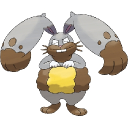

In [28]:
cv2_imshow(imgs[5])

That last cell will take a while, a few minutes at most.

In [29]:
imgs = np.array(imgs,float)/255

## Time to define the network


Here are some resources that were helpful:
1. `https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73`
2. `https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence`
3. `https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal`

In [30]:
import tensorflow.keras as k
import tensorflow as tf

In [31]:
from tensorflow.keras.layers import Conv2D, Dense, Input, LeakyReLU, Flatten, Activation,Conv2DTranspose, Multiply, Add, GaussianNoise, Subtract, Reshape
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy,KLD
from tensorflow.keras.backend import abs
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

Defining the encoder

In [32]:
e0 = Input((128,128,3))

e1 = Conv2D(32,3,2)(e0)
e2 = LeakyReLU()(e1)

e3 = Conv2D(64,3,2)(e2)
e4 = LeakyReLU()(e3)

e5 = Conv2D(64,3,2)(e4)
e6 = LeakyReLU()(e5)

e7 = Conv2D(64,3,2)(e6)
e8 = LeakyReLU()(e7)

e9 = Conv2D(64,3,2)(e8)
e10 = LeakyReLU()(e9)

e11 = Conv2D(64,3)(e10)
e12 = LeakyReLU()(e11)

e13 = Flatten()(e12)

mu = Dense(1000, activation=relu)(e13)
sigma = Dense(1000, activation=relu)(e13)

zero = Subtract()([sigma,sigma])
norm = GaussianNoise(1)(zero)

sigma_x_norm = Multiply()([sigma,norm])
enc_o = Add()([mu,sigma_x_norm])

encoder = Model(inputs = e0,outputs = enc_o)

In [33]:
encoder.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 63, 63, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 63, 63, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 31, 31, 64)   18496       leaky_re_lu_11[0][0]             
_______________________________________________________________________________________

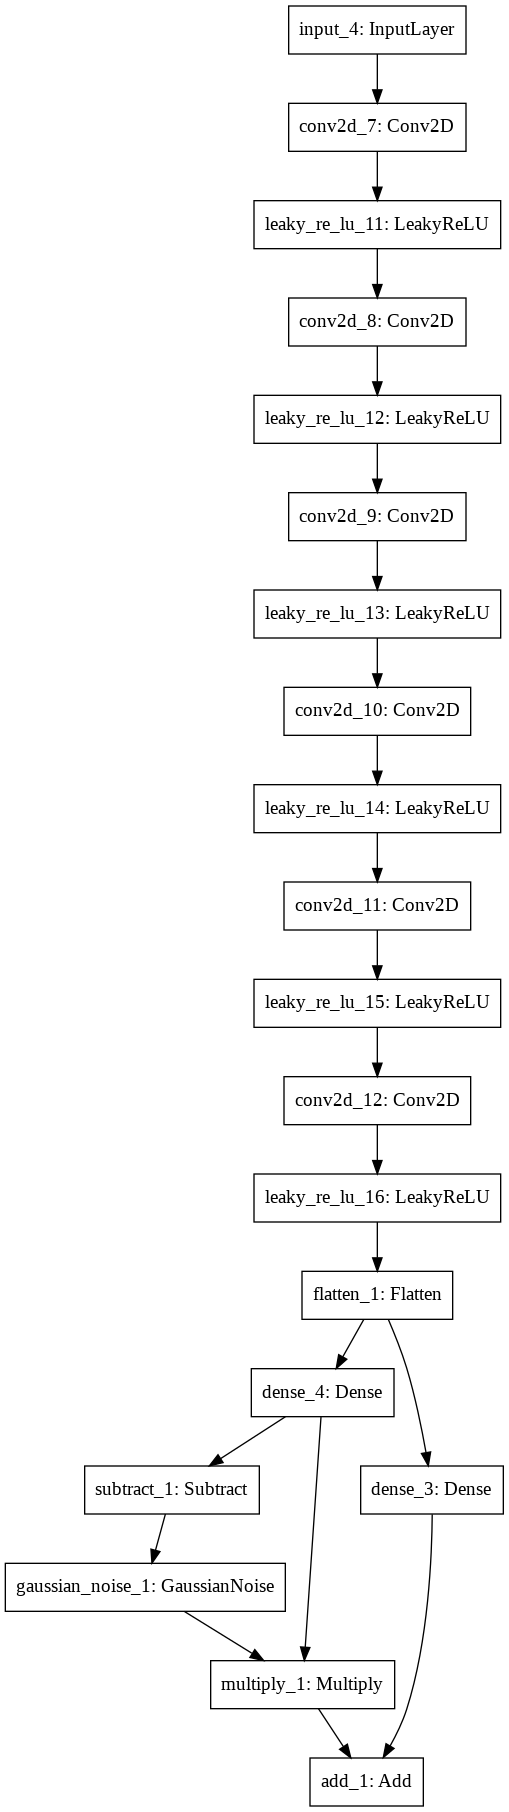

In [34]:
tf.keras.utils.plot_model(encoder)

Defining the decoder

In [35]:
d0 = Input((1000))

d1 = Dense(4096)(d0)
d2 = Reshape((8,8,64))(d1)

d3 = Conv2DTranspose(64,3,2,padding='same')(d2)
d4 = LeakyReLU()(d3)

d5 = Conv2DTranspose(64,3,2,padding='same')(d4)
d6 = LeakyReLU()(d5)

d7 = Conv2DTranspose(64,3,2,padding='same')(d6)
d8 = LeakyReLU()(d7)

d9 = Conv2DTranspose(32,3,2,padding='same')(d8)
d10 = LeakyReLU()(d9)

d11 = Conv2D(3,3,padding="same")(d10)
d12 = LeakyReLU()(d11)

d13 = Activation('sigmoid')(d12)

decoder = Model(inputs=d0,outputs=d13)

In [36]:
decoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              4100096   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 64)       

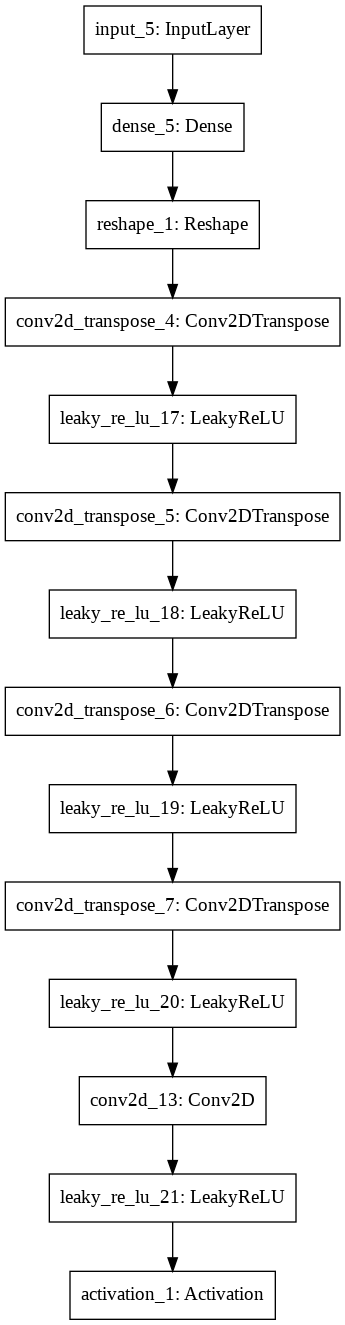

In [37]:
tf.keras.utils.plot_model(decoder)

Now to make a composite model

In [38]:
vae_input = Input(shape = (128,128,3))
encoded = encoder(vae_input)
vae_output = decoder(encoded)
vae = Model(inputs = vae_input,outputs = vae_output)

In [39]:
vae.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
functional_7 (Functional)    (None, 1000)              297104    
_________________________________________________________________
functional_9 (Functional)    (None, 128, 128, 3)       4230211   
Total params: 4,527,315
Trainable params: 4,527,315
Non-trainable params: 0
_________________________________________________________________


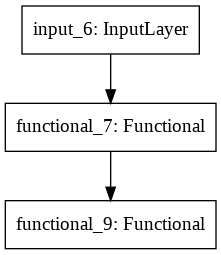

In [40]:
tf.keras.utils.plot_model(vae)

### Losses and Compilation

In [41]:
def vae_loss(y_true,y_pred):
  #Maybe look into 'untangled VAE' or something like that.
  return KLD(y_true,y_pred) + binary_crossentropy(y_true,y_pred)

In [42]:
vae.compile(
    optimizer = 'adam',
    loss = vae_loss,
    metrics=['accuracy','kullback_leibler_divergence','binary_crossentropy']
)

In [43]:
encoder.compile(
    optimizer = 'adam',
    metrics=['accuracy','kullback_leibler_divergence','binary_crossentropy']
)

In [44]:
decoder.compile(
    optimizer = 'adam',
    metrics=['accuracy','kullback_leibler_divergence','binary_crossentropy']
)

## Loading back the data and training

In [ ]:
vae.fit(imgs,imgs,batch_size=200, epochs = 2000)

Epoch 1/2000
5/5 [==============================] - 1s 235ms/step - loss: 0.4451 - accuracy: 0.3086 - kullback_leibler_divergence: -0.0305 - binary_crossentropy: 0.4756
Epoch 2/2000
5/5 [==============================] - 1s 233ms/step - loss: 0.3803 - accuracy: 0.2417 - kullback_leibler_divergence: -0.1947 - binary_crossentropy: 0.5750
Epoch 3/2000
5/5 [==============================] - 1s 227ms/step - loss: 0.3478 - accuracy: 0.2030 - kullback_leibler_divergence: -0.1444 - binary_crossentropy: 0.4922
Epoch 4/2000
5/5 [==============================] - 1s 229ms/step - loss: 0.3228 - accuracy: 0.2051 - kullback_leibler_divergence: -0.1919 - binary_crossentropy: 0.5146
Epoch 5/2000
5/5 [==============================] - 1s 229ms/step - loss: 0.3121 - accuracy: 0.2632 - kullback_leibler_divergence: -0.1885 - binary_crossentropy: 0.5005
Epoch 6/2000
5/5 [==============================] - 1s 236ms/step - loss: 0.3053 - accuracy: 0.3216 - kullback_leibler_divergence: -0.1823 - binary_crossen

### Trying it out

Real image vs Reconstructed image

In [ ]:
i = 78
pred = vae.predict(np.array([imgs[i]]))
cv2_imshow(imgs[i]*255)

In [ ]:
cv2_imshow(pred[0]*255)

Lets try some interpolation:
Pick two images, and get their latent vectors `a` and `b`

In [ ]:
a = encoder.predict(np.array([imgs[11]]))
b = encoder.predict(np.array([imgs[78]]))

In [ ]:
cv2_imshow(imgs[11]*255)

In [ ]:
cv2_imshow(imgs[78]*255)

In [ ]:
#@title  { run: "auto" }
x = 0.795 #@param {type:"slider", min:0, max:1, step:0.001}
interpolation = (a*x+b*(1-x))/2
prediction = decoder.predict(interpolation)
cv2_imshow((255*prediction[0]/prediction[0].max()))

### Let's save the model, convert and export

In [ ]:
!pip install tensorflowjs
import tensorflowjs as tfjs

In [ ]:
!mkdir js_encoder js_decoder
tfjs.converters.save_keras_model(encoder,'js_encoder')
tfjs.converters.save_keras_model(decoder,'js_decoder')

In [ ]:
encoder.save('encoder')
decoder.save('decoder')

Set `download_model = True` to download the model

In [ ]:
download_model = False
if download_model:
  !zip -r js_encoder.zip js_encoder
  !zip -r js_decoder.zip js_decoder
  from google.colab import files
  files.download("js_encoder.zip")
  files.download("js_decoder.zip")

### Sidenote: also export some images for the demo

In [ ]:
!mkdir exportImgs
for j in range(50):
  i = np.random.randint(0,imgs.shape[0])
  
  cv2.imwrite("exportImgs/"+str(j)+".jpg",imgs[i]*255)
!zip -r exportImgs.zip exportImgs

In [ ]:
downloadImgs = False
if downloadImgs:
  from google.colab import files
  files.download("exportImgs.zip")

In [ ]:
decoder.save('decoder')

In [ ]:
encoder.save('encoder')

In [ ]:
!zip -r decoder.zip decoder